In [22]:
## Written by Devanshu Thakar
!pwd
!ls

/home/devanshu/Documents/Summer2021/test-wrapper
analysis.ipynb	  fragments    NX10degrade     write_ndx.c
clus_nums.txt	  fragments.c  plot.txt        write_ndx.c.master
cluster_size.txt  hist.txt     Rg.in.master
config.dat	  loop.sh      traj.lammpstrj
fragment_id.txt   NX10	       write_ndx


In [23]:
import numpy as np
import time as clock
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import math
import subprocess
import sys

In [24]:
# Parameters (list all parameters here)
No = 836                          # Number of degradable bonds
rate = 4.5*10**(-5)               # degradation rate constant
tstart = 2200000                  # Start time-step in lammps simulation. 
tstep = 5000                      # Numerical time step in lammps simulation
tend = 8200000                    # End time-step in lammps simulation      
timestep = 0.02                   # Conversion for lammps timestep (tstep) to reduced time in reduced DPD unit

dir = "NX10/"                               # Path to simulation directory
dest = dir + "degrade/sim{}/"                # Path to degradation simulations
processed = dest + "processed/"              # Directory for saving the analyzed data files
lammps = "/home/devanshu/Documents/lammps/"   # Path to your lammps for analysis
results = dir+"degrade/result/"              # Path to directory to save the averaged data 
plot_dir = results+"plots/"                  # Path to deirectory to save plots

colour = 'k'                      # colour variable controls the color of plots
# For more color options see https://matplotlib.org/stable/gallery/color/named_colors.html
save_data = True                  # Save the averaged data  
save_plot = True                  # Save the plots
step = 20                         # Step parameter to control the spacing between error bars in the plot

no_sim = [1]                                 # List of all simulation runs

In [25]:
if(save_data):
    subprocess.run(["mkdir", "-p", results])
    subprocess.run(["mkdir", "-p", plot_dir])

In [26]:
bondsBroken = []  
# This is a list numpy arrays; numpy array stores the bonds_broken.txt for each sim
bad_sim = []      
# To list the sim that caused the exception
for i in no_sim:
    try:
        bondsBroken.append(np.loadtxt(dest.format(i) + "bonds_broken.txt"))
    except IOError:
        print ("Interrupt Kernel since bonds_broken.txt is not found in",dir,"/degrade/sim",i)
        inp = input()
        print ('Interrupted Kernel, check your data folders')
        bad_sim.append(i)

    else:  
        print ("read bonds_broken.txt data from/degrade/sim",i)

if(len(bondsBroken)):
    # np.dstack - The list bondsBroken is modified to numpy array with shape (# of rows, # of columns, # of sim) by stacking the elements
    BONDSbroken = np.dstack(bondsBroken)
    no_rows = np.shape(BONDSbroken[:,0,0])[0]

# Exception sims are deleted from no_sim
for x in bad_sim:
    no_sim.remove(x)

read bonds_broken.txt data from/degrade/sim 1


In [27]:
# Taking the average and standard deviation along the axis=2 (the third dimension of numpy array) (# of simulations). 
avg_BB = np.mean(BONDSbroken, axis=2)
std_BB = np.std(BONDSbroken, axis=2)

In [28]:
# Check if the time column from the every sim and avg_BB is same or not
t = BONDSbroken[:,0,0].reshape(np.shape(BONDSbroken)[0],1)      
t_avg = avg_BB[:,0].reshape(np.shape(avg_BB)[0],1)
if((t==t_avg).all()):
    print("Time column in bonds_broken.txt is same for every simulations.")
else:
    print("Different time found in time column")

Time column in bonds_broken.txt is same for every simulations.


In [29]:
bonds_broken = BONDSbroken[:,0,0].reshape(np.shape(BONDSbroken)[0],1)             
# Stores the bonds broken data in columns like (time, data for sim1, data for sim2, .... etc.)
frac_bonds_intact = BONDSbroken[:,0,0].reshape(np.shape(BONDSbroken)[0],1)
# Stores the fraction of bonds intact for all sims in columns like (time, data for sim1, data for sim2,.... etc.)
for i in range(len(no_sim)):
    tmp = BONDSbroken[:,1,i].reshape(np.shape(BONDSbroken)[0],1)
    bonds_broken=np.hstack((bonds_broken, tmp))
    # Computes the fraction of bonds intact for each sim
    tmp = (No-tmp)/No
    frac_bonds_intact = np.hstack((frac_bonds_intact, tmp))

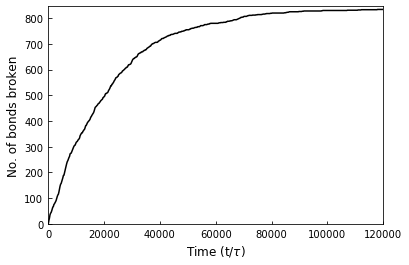

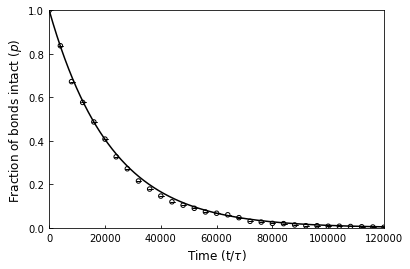

In [30]:
no_rows=np.shape(avg_BB)[0]
no_rows1=np.shape(avg_BB)[0]
time = avg_BB[:,0].reshape(no_rows,1)
# avg. fraction of bonds intact - Calculated as the fraction of bonds intact using the average number of bonds broken broken
avg_bonds_intact = ( (No - avg_BB[:,1])/No).reshape(no_rows,1)
std_devia_frac = (std_BB[:,1]/No).reshape(no_rows, 1)
exponen = np.exp(-(rate)*avg_BB[:,0])

plt.xlim([0, time[-1]])
plt.ylim([0, No+10])
plt.plot(time, avg_BB[:,1],  label="No. of bons broken",color=colour)
plt.xlabel("Time "+'(t/'+r'$\tau$)',fontsize=12)
plt.ylabel("No. of bonds broken", fontsize=12)
plt.tick_params(axis="y",direction="in", pad=5)
plt.tick_params(axis="x",direction="in", pad=5)
if save_plot:
    plt.savefig(plot_dir+"bondsBroken.png", dpi=300, bbox_inches='tight')
plt.show()

plt.xlim([0, time[-1]])
plt.ylim([0, 1])
plt.plot(time, exponen, label="exp(-kt)", color=colour)
plt.scatter(time[0:no_rows:step], avg_bonds_intact[0:no_rows:step], s=20, facecolors='none', edgecolors=colour)
plt.errorbar(time[0:no_rows:step], avg_bonds_intact[0:no_rows:step], yerr=std_devia_frac[0:no_rows:step][:,0],fmt=' ', color=colour, solid_capstyle='projecting', capsize=2.5)
plt.xlabel("Time "+'(t/'+r'$\tau$)',fontsize=12)
plt.ylabel("Fraction of bonds intact" + ' ($p$) ', fontsize=12)
plt.tick_params(axis="y",direction="in", pad=5)
plt.tick_params(axis="x",direction="in", pad=5)
if save_plot:
    plt.savefig(plot_dir+"bondsIntact.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
def execution_status(x, sim_no):
    logfile = open('analysis.log', 'a')
    
    if(x.returncode==0):
        if(x.stdout):
            logfile.write(x.stdout)
        return True
    else:
        if(x.stderr):
            logfile.write(x.stderr)
        if(x.stdout):
            logfile.write(x.stdout)
        print("Error occured in sim{}. See analysis.log. Exiting the loop!".format(str(sim_no)))
        return False

In [36]:
i=1
s = clock.time()
# compile 
x=subprocess.run(["gcc", "fragments.c", "-o", "fragments"], capture_output=True, text=True)

# clean up files from previous, possibly incomplete analysis
subprocess.run(["rm", "cluster_size.txt", "plot.txt", "hist.txt", "clus_nums.txt","atomfile.txt"])

# link trajectories and other input files to analyze 
subprocess.run(["ln", "-sf", dest.format(i)+"frag.lammpstrj", "fragment_id.txt"], 
                   text=True, capture_output=True)
# This hydrogel linking is different for adsorb. Right now a copy is place in dir...Modify this later
subprocess.run(["ln", "-sf", dir+"hydrogel.dat", "config.dat"], text=True, capture_output=True)
subprocess.run(["ln", "-sf", dest.format(i)+"traj.lammpstrj", "traj.lammpstrj"], 
                   text=True, capture_output=True)
    
# get total # of beads for current trajectory from config file
natoms = int( (subprocess.run(["awk 'FNR == 3 {print $1}' config.dat"], 
                                  shell=True, capture_output=True, text=True)).stdout )
    
# set total beads and time step size in write_ndx.c file and compile
subprocess.run(['''sed -e "s/NATOMS/{}/g" -e "s/TSTEP/{}/g" write_ndx.c.master > write_ndx.c 
                               '''.format(natoms, tstep)], shell=True, capture_output=True, text=True)
    
subprocess.run(["gcc", "write_ndx.c", "-o", "write_ndx"], capture_output=True, text=True)
    

# extract fragment data from lammps dump file
subprocess.run(["./fragments"], capture_output=True, text=True);
    
# analysis loop -- loop over LAMMPS time steps
# Add execute permission to loop.sh
subprocess.run(["chmod","+x","loop.sh"])
e = clock.time()
print("The analysis for sim" + str(i) + " take " + str((e-s)/60) + " minutes to finish.")

The analysis for sim1 take 0.11816688776016235 minutes to finish.


In [37]:
print(natoms)

9996


In [35]:
x=subprocess.run(["./loop.sh {} {} {}".format(tstart, tend, tstep)], shell=True, capture_output=True, text=True)

KeyboardInterrupt: 

In [45]:
# Creating a processed directory inside sim to store the results
subprocess.run(["mkdir", "-p", processed.format(i)]) 

#   move generated data to appropriate directory 
subprocess.run(["mv", "plot.txt", processed.format(i)+"frag_plot.txt"])
subprocess.run(["mv", "hist.txt", processed.format(i)+"frag_hist.txt"])
subprocess.run(["mv", "cluster_size.txt", processed.format(i)+"fragment_size.txt"])
subprocess.run(["mv", "clus_nums.txt", processed.format(i)+"frag_nums.txt"])
subprocess.run(["mv", "atomfile.txt", processed.format(i)+"atomfile.txt"])
subprocess.run(["mv", "rg.txt", processed.format(i)+"rg.txt"])  
    
logfile = open('analysis.log', 'a')
logfile.write('\n'+"#####################" + " END of sim" + str(i) + " ######################" + '\n\n')
# To remove the link files 
subprocess.run(["rm", "config.dat", "fragment_id.txt", "traj.lammpstrj"], capture_output=True, text=True)

CompletedProcess(args=['rm', 'config.dat', 'fragment_id.txt', 'traj.lammpstrj'], returncode=0, stdout='', stderr='')

In [53]:
# For the analysis loop - over LAMMPS time step a bash script loop.sh is used
open('analysis.log', 'w')

for i in no_sim: 
    s = clock.time()
    # compile 
    x=subprocess.run(["gcc", "fragments.c", "-o", "fragments"], capture_output=True, text=True)
    if (not execution_status(x,i)): break

    # clean up files from previous, possibly incomplete analysis
    subprocess.run(["rm", "cluster_size.txt", "plot.txt", "hist.txt", "clus_nums.txt","atomfile.txt"])

    #link trajectories and other input files to analyze 
    subprocess.run(["ln", "-sf", dest.format(i)+"frag.lammpstrj", "fragment_id.txt"], 
                   text=True, capture_output=True)
    subprocess.run(["ln", "-sf", dir+"hydrogel.dat", "config.dat"], text=True, capture_output=True)
    subprocess.run(["ln", "-sf", dest.format(i)+"traj.lammpstrj", "traj.lammpstrj"], 
                   text=True, capture_output=True)
    
    # get total # of beads for current trajectory from config file
    natoms = int( (subprocess.run(["awk 'FNR == 3 {print $1}' config.dat"], 
                                  shell=True, capture_output=True, text=True)).stdout )
    
    # set total beads and time step size in write_ndx.c file and compile
    subprocess.run(['''sed -e "s/NATOMS/{}/g" -e "s/TSTEP/{}/g" write_ndx.c.master > write_ndx.c 
                               '''.format(natoms, tstep)], shell=True, capture_output=True, text=True)
    
    subprocess.run(["gcc", "write_ndx.c", "-o", "write_ndx"], capture_output=True, text=True)
    

    # extract fragment data from lammps dump file
    subprocess.run(["./fragments"], capture_output=True, text=True);
    
    # analysis loop -- loop over LAMMPS time steps
    subprocess.run(["chmod","+x","loop.sh"])
    x=subprocess.run(["./loop.sh {} {} {}".format(tstart, tend, tstep)], shell=True, capture_output=True, text=True)
    if (not execution_status(x,i)): break
    
    # generate loop index to substitute in LAMMPS analysis file
    loopindex = ((tend-tstart)//tstep) + 1
    
    # generate LAMMPS analysis file 
    subprocess.run(['''sed -e "s/TSTART/{}/g" -e "s/TSTEP/{}/g" -e "s/INDEX/{}/g" Rg.in.master > Rg.in'''.format(str(tstart), str(tstep), str(loopindex))], capture_output=True, shell=True)
    
    # analyze 
    x=subprocess.run([lammps+"src/lmp_serial< Rg.in"], shell=True)
    if (not execution_status(x,i)): break
    
    # Creating a processed directory inside sim to store the results
    subprocess.run(["mkdir", "-p", processed.format(i)]) 

    #   move generated data to appropriate directory 
    subprocess.run(["mv", "plot.txt", processed.format(i)+"frag_plot.txt"])
    subprocess.run(["mv", "hist.txt", processed.format(i)+"frag_hist.txt"])
    subprocess.run(["mv", "cluster_size.txt", processed.format(i)+"fragment_size.txt"])
    subprocess.run(["mv", "clus_nums.txt", processed.format(i)+"frag_nums.txt"])
    subprocess.run(["mv", "atomfile.txt", processed.format(i)+"atomfile.txt"])
    subprocess.run(["mv", "rg.txt", processed.format(i)+"rg.txt"])  
    
    logfile = open('analysis.log', 'a')
    logfile.write('\n'+"#####################" + " END of sim" + str(i) + " ######################" + '\n\n')
    # To remove the link files 
    subprocess.run(["rm", "config.dat", "fragment_id.txt", "traj.lammpstrj"], capture_output=True, text=True)
    e = clock.time()
    print("The analysis for sim" + str(i) + " take " + str((e-s)/60) + " minutes to finish.")

Error occured in sim1. See analysis.log. Exiting the loop!


In [21]:
plots = []

for i in no_sim:
    # columns:  timestep, dpn, dpw, dpw_r, pdi, max, q, dpz, dpz_r
    plots.append(np.loadtxt(processed.format(i) + "frag_plot.txt"))
    
PLOTS = np.dstack(plots)
average = np.mean(PLOTS, axis=2)
std_deviation = np.std(PLOTS,axis=2)

In [22]:
### GLOBAL PEAK finder
t_peak = []
dpw_r_peak = []
for i in range(len(no_sim)):
    tmp1,tmp2 = 0, 0
    for j in range(1,np.shape(PLOTS)[0]-1):
        # columns:  timestep, dpn, dpw, dpw_r, pdi, max, q, dpz, dpz_r
        if(PLOTS[j,3,i]>tmp2):
            tmp2 =PLOTS[j,3,i]
            tmp1 =(PLOTS[j,0,i] -tstart)*timestep
    t_peak.append(tmp1)
    dpw_r_peak.append(tmp2)

In [23]:
print(t_peak)
print(dpw_r_peak)

[14000.0, 14200.0, 13900.0, 14300.0, 14900.0]
[926.854922, 1308.51634, 1089.20155, 1002.735099, 691.0]


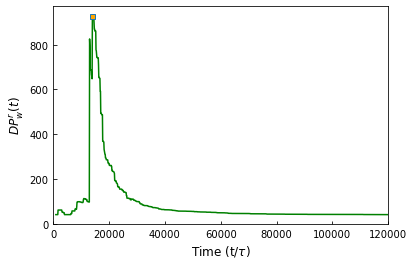

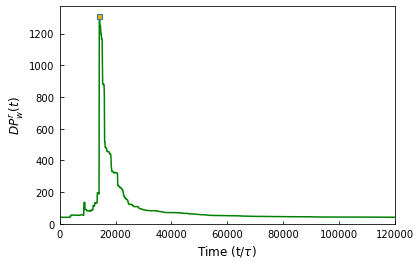

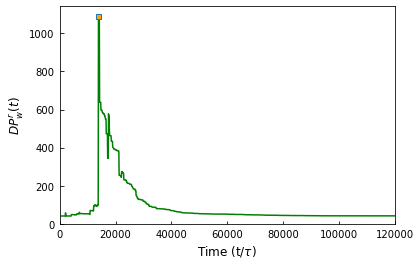

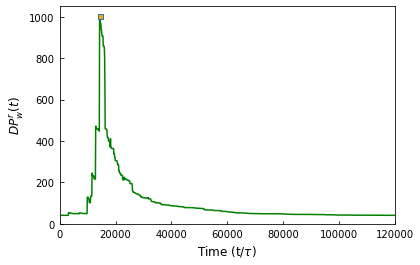

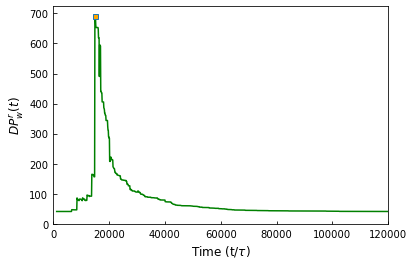

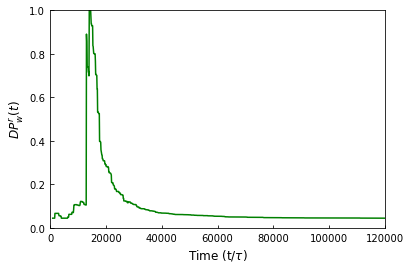

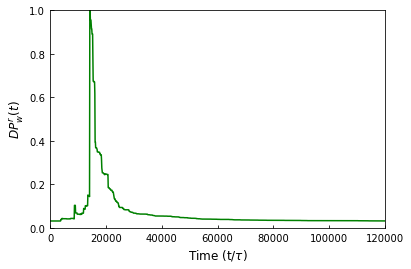

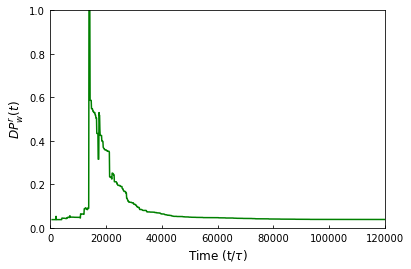

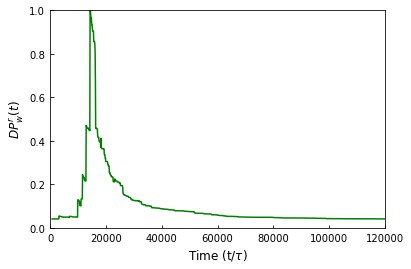

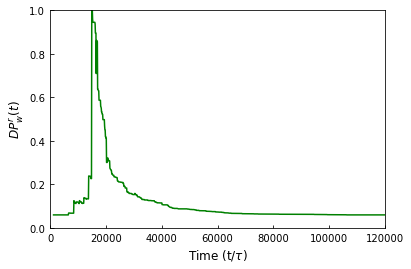

In [24]:
dpw_r = []
for i in range(len(no_sim)):
    dpw_r.append(PLOTS[:,3,i])
    time = (PLOTS[:,0,i] - tstart)*timestep
    plt.plot(time, PLOTS[:,3,i],  label="dpw_r for sim"+str(no_sim[i]), color=colour)
    plt.plot(t_peak[i], dpw_r_peak[i], 's',markerfacecolor='orange',  markersize=5)
    plt.xlim([0, time[-1]])
    plt.ylim(bottom=0)
    plt.xlabel("Time "+'(t/'+r'$\tau$)',fontsize=12)
    plt.ylabel(r'$DP_w^r (t)$',fontsize=12)
    plt.tick_params(axis="y",direction="in", pad=5)
    plt.tick_params(axis="x",direction="in", pad=5)
    if save_plot:
        plt.savefig(plot_dir+"dataset"+str(no_sim[i])+".dpw_r.png", dpi=300, bbox_inches='tight')
    plt.show()

    
fig, ax = plt.subplots()
ax.set_ylim([0, 1])
for i in range(len(no_sim)):
    ax.plot(time, PLOTS[:,3,i]/dpw_r_peak[i],  label="dpw_r for sim"+str(no_sim[i]), color=colour)
    ax.set_xlim([0, time[-1]])
    
ax.set_xlabel("Time "+'(t/'+r'$\tau$)',fontsize=12)
ax.set_ylabel(r'$DP_w^r (t)$',fontsize=12)
ax.tick_params(axis="y",direction="in", pad=5)
ax.tick_params(axis="x",direction="in", pad=5)
plt.savefig("dpw_r_nomralized" ".png", dpi=300, bbox_inches='tight')

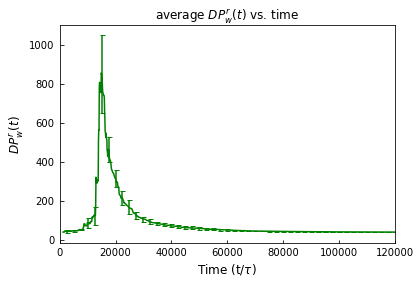

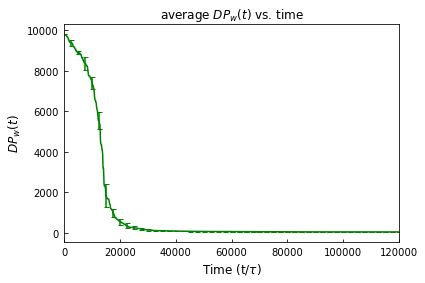

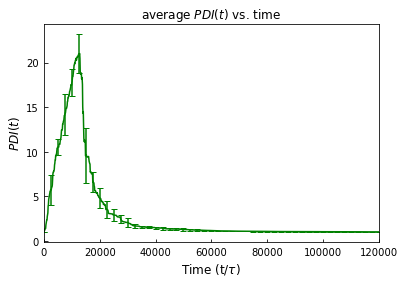

In [25]:
# columns:  timestep, dpn, dpw, dpw_r, pdi, max, q, dpz, dpz_r
no_rows = np.shape(PLOTS)[0]
time = (average[:,0] - tstart)*timestep

dpw = average[:,2]
dpw_r = average[:,3]
pdi = average[:,4]

fig, ax = plt.subplots()
ax.plot(time, dpw, label = "dpw",color=colour)
plt.errorbar(time[0:no_rows:step], dpw[0:no_rows:step], yerr=std_deviation[:,2][0:no_rows:step],fmt=' ', color=colour, solid_capstyle='projecting', capsize=2.5)
ax.set_title('average '+r'$DP_w (t)$' +' vs. time',fontsize=12)
ax.set_xlim([0, time[-1]])
ax.set_xlabel("Time "+'(t/'+r'$\tau$)',fontsize=12)
ax.set_ylabel(r'$DP_w (t)$',fontsize=12)
ax.tick_params(axis="y",direction="in", pad=5)
ax.tick_params(axis="x",direction="in", pad=5)
if save_plot:
    plt.savefig(plot_dir+"dpw.png", dpi=300, bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(time, pdi, label = "pdi set 1", color=colour)
plt.errorbar(time[0:no_rows:step], pdi[0:no_rows:step], yerr=std_deviation[:,4][0:no_rows:step], fmt=' ', color=colour, solid_capstyle='projecting', capsize=3)
ax.set_title('average '+r'$PDI(t)$' +' vs. time',fontsize=12)
ax.set_xlim([0, time[-1]])
ax.set_xlabel("Time "+'(t/'+r'$\tau$)',fontsize=12)
ax.set_ylabel(r'$PDI(t)$',fontsize=12)
ax.tick_params(axis="y",direction="in", pad=5)
ax.tick_params(axis="x",direction="in", pad=5)
if save_plot:
    plt.savefig(plot_dir+"pdi.png", dpi=300, bbox_inches='tight')

In [26]:
rg = []
for i in no_sim:
    # columns : timestep, rg 
    rg.append(np.loadtxt(processed.format(i) + "rg.txt"))

RG = np.dstack(rg)
avg_rg = np.mean(RG, axis=2)
std_rg = np.std(RG, axis=2)

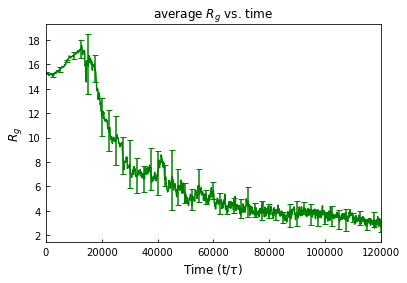

In [27]:
# columns:  timestep, rg
time = (avg_rg[:,0] - tstart)*timestep
rg = avg_rg[:,1]

fig, ax = plt.subplots()
ax.plot(time, rg, label = "rg", color=colour)
plt.errorbar(time[0:no_rows:step], rg[0:no_rows:step], yerr=std_rg[:,1][0:no_rows:step], fmt=' ', color=colour, solid_capstyle='projecting', capsize=3)
ax.set_title('average '+r'$R_g$' +' vs. time',fontsize=12)
ax.set_xlim([0, time[-1]])
ax.set_xlabel("Time "+'(t/'+r'$\tau$)',fontsize=12)
ax.set_ylabel(r'$R_g$',fontsize=12)
ax.tick_params(axis="y",direction="in", pad=5)
ax.tick_params(axis="x",direction="in", pad=5)
if save_plot:
    plt.savefig(plot_dir+"Rg.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# Columns in shape - step, l1, l2, l3, I1, I2, I3, k^2
shape = []
for i in no_sim:
    # Columsn in shape - step, l1, l2, l3, I1, I2, I3, k^2
    shape.append(np.loadtxt(processed.format(i) + "shape.txt"))

SHAPE = np.dstack(shape)
avg_shape = np.mean(SHAPE, axis=2)
std_shape = np.std(SHAPE, axis=2)

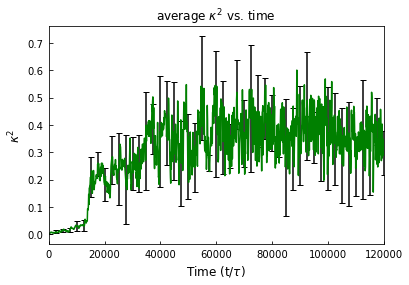

In [30]:
# Columns in shape - step, l1, l2, l3, I1, I2, I3, k^2
time = (avg_shape[:,0] - tstart)*timestep
ksquare = avg_shape[:,7]

fig, ax = plt.subplots()
plt.errorbar(time[0:no_rows:step], ksquare[0:no_rows:step], yerr=std_shape[:,7][0:no_rows:step], fmt=' ', color='k', solid_capstyle='projecting', capsize=3)
ax.plot(time, ksquare, label = "k^2", color=colour)
ax.set_title('average '+r'$\kappa^2$' +' vs. time',fontsize=12)
ax.set_xlim([0, time[-1]])
ax.set_xlabel("Time "+'(t/'+r'$\tau$)',fontsize=12)
ax.set_ylabel(r'$\kappa^2$',fontsize=12)
ax.tick_params(axis="y",direction="in", pad=5)
ax.tick_params(axis="x",direction="in", pad=5)
if save_plot:
    plt.savefig(plot_dir+"k_square.png", dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Saving the average data - fmt="%0.6f" indicates that saved data is precise to 6 decimal places.
if(save_data):
    tmp = np.hstack((avg_BB, std_BB[:,1].reshape(np.shape(std_BB)[0],1)))
    np.savetxt(results+"bonds_broken_average.txt", tmp, fmt="%0.3f", delimiter=" ", newline="\n")
    
    # time1=avg_BB[:,0].reshape(std_BB[0],1)
    tmp = np.hstack((avg_BB[:,0].reshape(np.shape(avg_BB)[0],1), avg_bonds_intact, std_devia_frac))
    np.savetxt(results+"fraction_bonds_intact_average.txt", tmp, fmt="%0.6f", delimiter= " ", newline="\n")
    
    file=open(results+"peak_dpw_r.txt", "w")
    for i in range(len(no_sim)):
        file.write(str(no_sim[i]) + " " + " " + str(t_peak[i]) + " " + str(dpw_r_peak[i])+"\n")
    file.close()
    
    # columns:  timestep, dpn, dpw, dpw_r, pdi, max, q, dpz, dpz_r
    tmp = np.hstack((time.reshape(no_rows,1), dpw.reshape(no_rows,1), std_deviation[:,2].reshape(no_rows,1)))
    np.savetxt(results+"dpw_average.txt", tmp, fmt="%0.6f", delimiter=" ", newline="\n")
    
    tmp=np.hstack((time.reshape(no_rows,1), pdi.reshape(no_rows,1), std_deviation[:,4].reshape(no_rows,1)))
    np.savetxt(results+"pdi_average.txt", tmp, fmt="%0.6f", delimiter=" ", newline="\n")
    
    no_rows=np.shape(avg_rg)[0]
    tmp=np.hstack((time.reshape(no_rows,1), avg_rg[:,1].reshape(no_rows,1), std_rg[:,1].reshape(no_rows,1)))
    np.savetxt(results+"rg_average.txt", tmp, fmt="%0.6f", delimiter=" ", newline="\n")
    
    np.savetxt(results+"shape_avg.txt", avg_shape,  fmt="%0.3f", delimiter=" ", newline="\n")
    np.savetxt(results+"shape_std.txt", std_shape,  fmt="%0.3f", delimiter=" ", newline="\n")

In [32]:
# Remove the log to the results directory
subprocess.run(["rm","analysis.log"])
subprocess.run(["mv", "log.lammps", results], capture_output=True, text=True)

CompletedProcess(args=['mv', 'log.lammps', '/home/nileshthakar/nanogels/NX20/reps6/r_64/degrade/result/'], returncode=1, stdout='', stderr="mv: cannot stat 'log.lammps': No such file or directory\n")